# Linear Programming: DMC Formulation
- Author: Siang Lim, March 2nd 2022

## References
- Morshedi, A. M., Cutler, C. R., & Skrovanek, T. A. (1985). Optimal solution of dynamic matrix control with linear programing techniques (LDMC). In 1985 American Control Conference (pp. 199-208). IEEE.
- Sorensen, R. C., & Cutler, C. R. (1998). LP integrates economics into dynamic matrix control. Hydrocarbon Processing, 77(9), 57-65.
- Ranade, S. M., & Torres, E. (2009). From dynamic mysterious control to dynamic manageable control. Hydrocarbon Processing, 88(3), 77-81.

# 1. DMC Overview

DMC (Dynamic Matrix Control) belongs to a family of controllers known as 'Model Predictive Control' (MPC).

One important point here is that DMC-type MPCs in the process industry are implemented with an integrated steady-state optimizer (usually LP) that generates SS targets for the MPC algorithm. This is something that's not often clear in academic papers, which usually focuses on the MPC algorithm itself.

DMC answers 3 questions about the process and how to control it.

1. **Where am I?** It uses empirical **models** from step tests to **predict** how the process is moving.
2. **Where should I go?**. It uses a steady-state LP optimizer to generate **SS targets** that keep the process at an economic optimum.
3. **How should I get there?** It generates a **move plan** to move the process to the optimum point based on these SS targets.

The LP steady-state (SS) optimizer is responsible for generating SS targets for the move calculations. We will look at this component first, and the Prediction and Move Plan modules in subsequent notebooks.

<div>
<br>
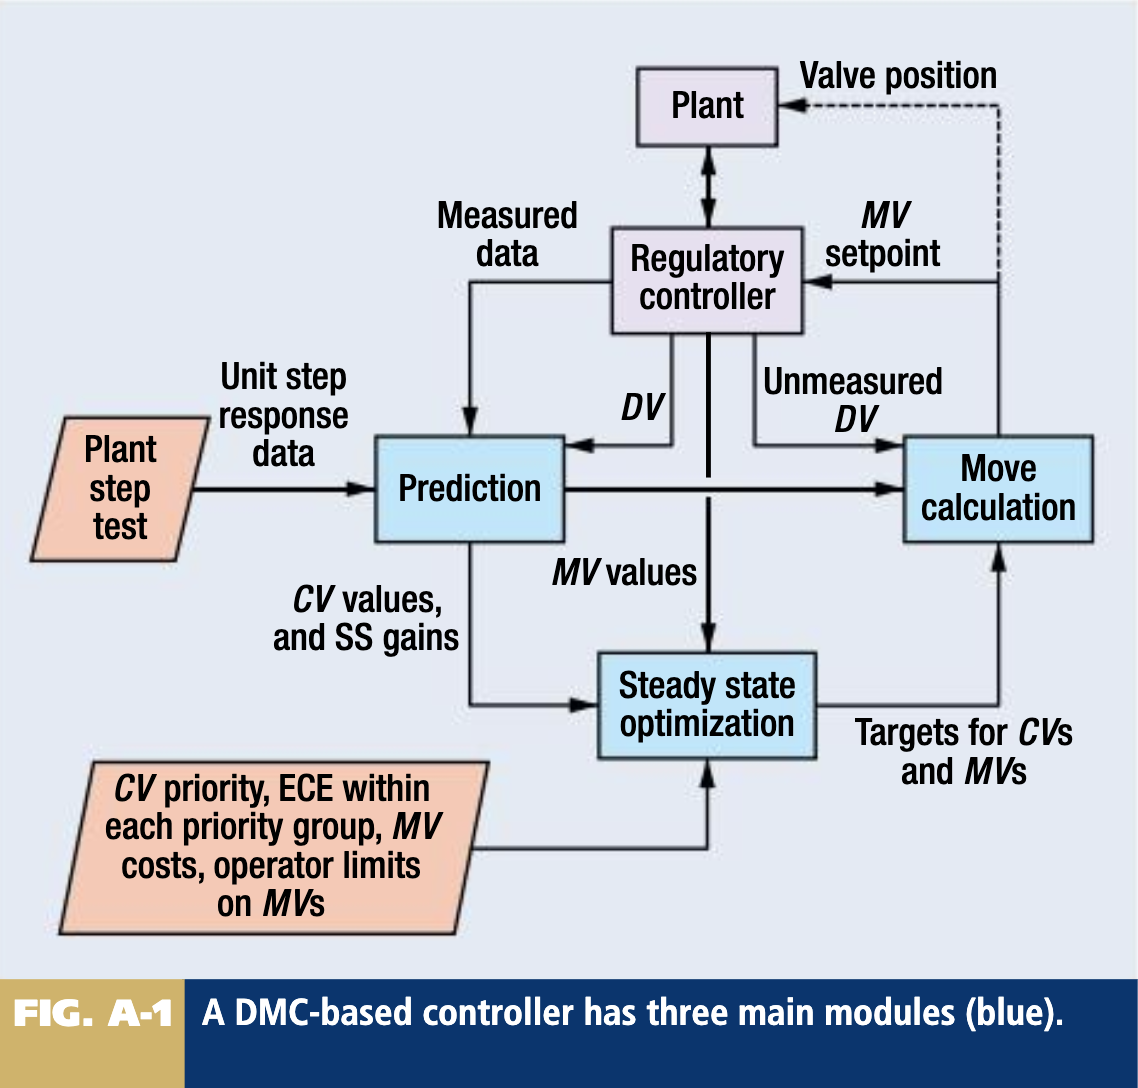
</div>

From: *Ranade, S. M., & Torres, E. (2009). From dynamic mysterious control to dynamic manageable control. Hydrocarbon Processing, 88(3), 77-81.*

$$\require{nicematrix}$$

# 2. The LP steady-state optimizer in DMC

In multivariable controllers, we have Manipulated Variables (MVs) which are handles that can be adjusted to move the process. The effects of moving the MVs are reflected in the Controlled Variable (CVs).

The steady-state relationship between an MV and a CV is captured by its **steady-state process gain**. In multivariable controllers, we have a **gain matrix** that captures the relationships between multiple MVs and CVs.

Consider a $2\times2$ gain matrix, $G$ with 2 MVs and 2 CVs. There will be 4 elements, where each $G_{ij}$ describes the relationship between the $i$-th CV and $j$-th MV.

$$
G =
    \begin{bmatrix}
        G_{11} & G_{12} \\
        G_{21} & G_{22}
    \end{bmatrix}
$$

Note that mathematically, the CVs are rows, and MVs are columns. This is the opposite of the usual convention in commercial MPC software, where the MVs are plotted as rows, and CVs as columns.

<div>
<br>
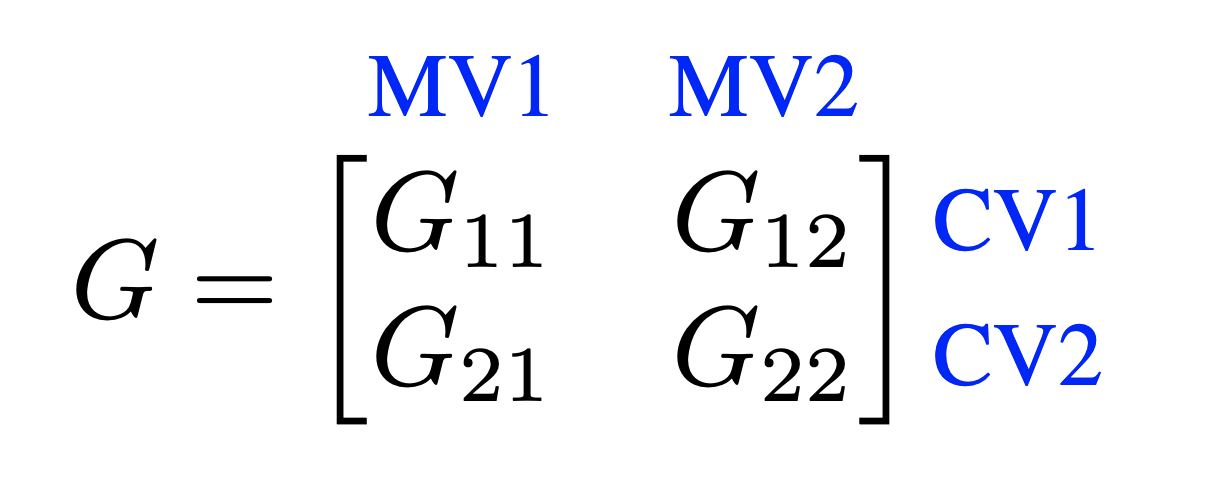
</div>

##  2.1 The debutanizer process

Let's look at a debutanizer process, which separates C4- molecules at the top of the column from heavier components at the bottom.

<div>
<br>
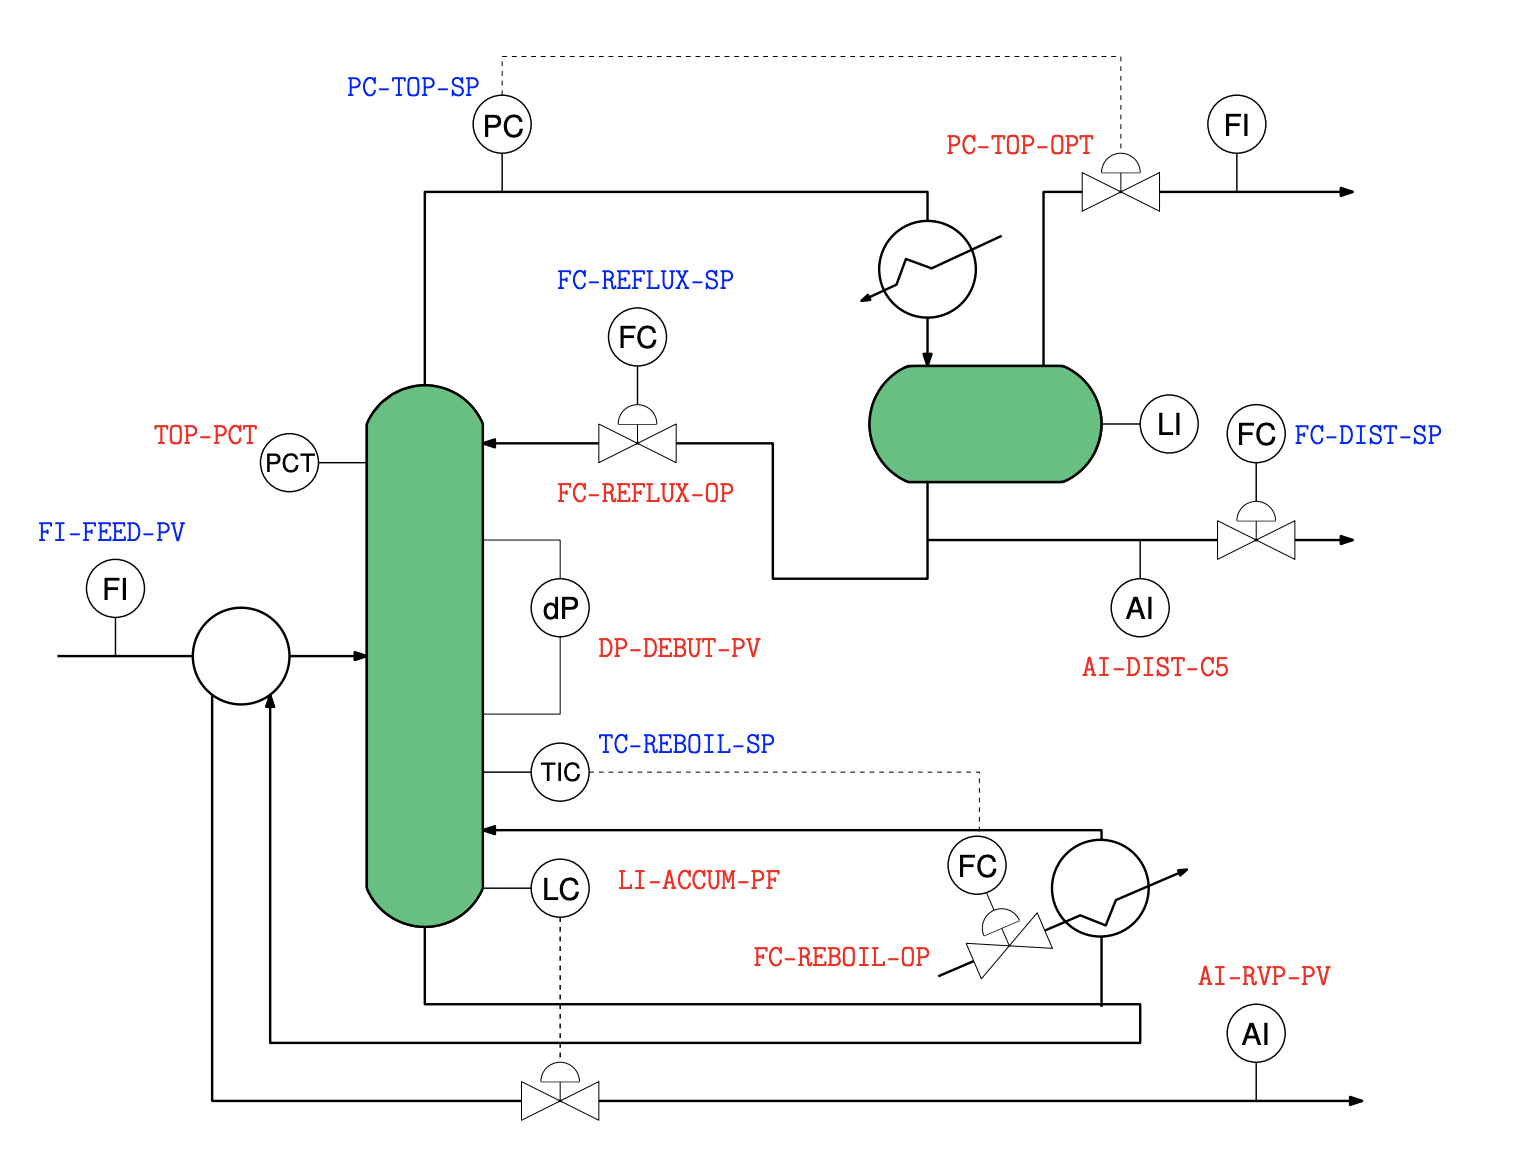
</div>

To simplify the problem, let's just consider 2 MVs and 2 CVs.

- **MV1:** Reboiler Temperature Control (TC-REBOILER)
- **MV2:** Reflux Flow Rate Control (FC-REFLUX)
- **CV1:** Bottoms RVP (AI-BTM-RVP)
- **CV2:** Overhead C5 Content (AI-TOP-C5)

The gain matrix is given as:
$$
G =
    \begin{bmatrix}
        -0.200 & -0.072 \\
        0.125 & -0.954
    \end{bmatrix}
$$

The gain matrix tells us that:
- Every unit increase in reboiler temperature reduces RVP by 0.20 units and increases C5 by 0.125 units.
- This makes sense, if we fire the reboiler harder, we boil stuff up the top so the bottom RVP decreases (less volatile, more heavier components), and some of the heavier components go up the column, so overhead C5 increases.
- Every unit increase in reflux reduces RVP by 0.072 units and reduces C5 by 0.954 units.
- This also makes sense, because increasing reflux improves separation (up to a certain point, considering flooding limits etc.)

## 2.2 MV-CV equations

Using the gain matrix, the CV relationship can be written in terms of its MVs:

$$
\Delta \text{CV}_{1} = G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \\ 
\Delta \text{CV}_{2} = G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} 
$$

We can impose upper and lower limits on the MVs:

$$
\text{MV}_{1, \text{Lo}} \leq \text{MV}_{1} \leq \text{MV}_{1, \text{Hi}}\\ 
\text{MV}_{2, \text{Lo}} \leq \text{MV}_{2} \leq \text{MV}_{2, \text{Hi}}\\
$$

As well as the CVs:

$$
\text{CV}_{1, \text{Lo}} \leq \text{CV}_{1} \leq \text{CV}_{1, \text{Hi}}\\ 
\text{CV}_{2, \text{Lo}} \leq \text{CV}_{2} \leq \text{CV}_{2, \text{Hi}}\\
$$

Since the CVs are related to the MVs by the gain matrix, we can substitute the equations to get CV limits in terms of MV movements:

$$
G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \leq \Delta \text{CV}_{1, \text{Hi}}\\
G_{11} \Delta \text{MV}_{1} + G_{12} \Delta \text{MV}_{2} \geq \Delta \text{CV}_{1, \text{Lo}}\\
G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} \leq \Delta \text{CV}_{2, \text{Hi}} \\
G_{21} \Delta \text{MV}_{1} + G_{22} \Delta \text{MV}_{2} \geq \Delta \text{CV}_{2, \text{Lo}} \\
$$

Let's see what this looks like:

In [50]:
# Just importing libraries and tweaking the plot settings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

# Gains and CV Limits

In [51]:
G11 = -0.200
G12 = -0.072
G21 = 0.125
G22 = -0.954

CV1Lo = -1
CV1Hi = 1

CV2Lo = -2
CV2Hi = 2.5

## 2.3 The Feasible Region

The shaded area below is known as the `feasible region` or `solution space` in the LP problem. It is defined based on the current process conditions and the distance of each variable from its constraints.

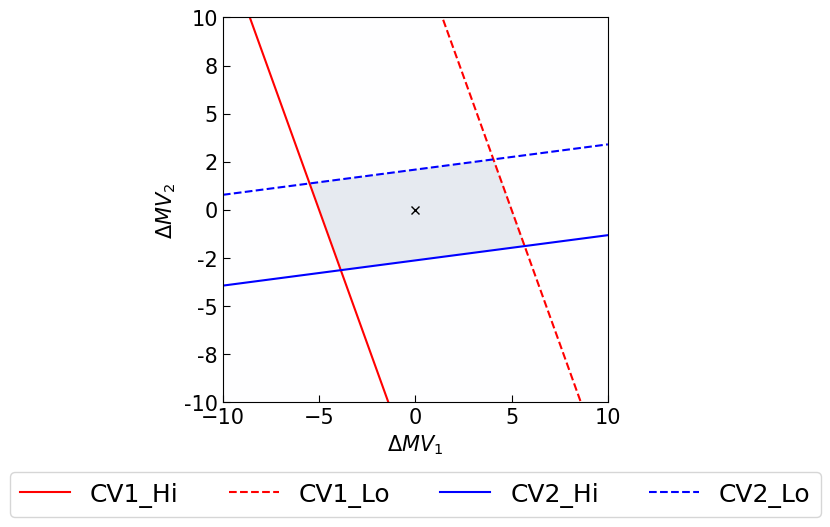

In [53]:
# %matplotlib inline
limits = 10
d = np.linspace(-limits, limits, 1000)
x,y = np.meshgrid(d,d)

# constraint formulation in terms of x and y
c1 = G11*x+G12*y <= CV1Hi
c2 = G11*x+G12*y >= CV1Lo
c3 = G21*x+G22*y <= CV2Hi
c4 = G21*x+G22*y >= CV2Lo

# equation of a line, y = mx + c
y_c1 = (CV1Hi - G11*d)/G12
y_c2 = (CV1Lo - G11*d)/G12
y_c3 = (CV2Hi - G21*d)/G22
y_c4 = (CV2Lo - G21*d)/G22

plt.figure(figsize=(10, 5))
plt.imshow((c1 & c2 & c3 & c4).astype(int), extent=(x.min(),x.max(),y.min(),y.max()), origin="lower", cmap="Blues", alpha=0.1);
plt.plot(d, y_c1, '-r', label='CV1_Hi');
plt.plot(d, y_c2, '--r', label='CV1_Lo');
plt.plot(d, y_c3, '-b', label='CV2_Hi');
plt.plot(d, y_c4, '--b', label='CV2_Lo');
plt.plot(0,0,'kx');

plt.xlim((-limits, limits))
plt.ylim((-limits, limits))
plt.xlabel(r'$\Delta MV_1$')
plt.ylabel(r'$\Delta MV_2$')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')); # No decimal places
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.33), ncol=4);

## 2.4 The optimum point (LP solution)
The feasible region tells us that the LP optimizer is allowed to move $\Delta MV_1$ and $\Delta MV_2$ within the shaded region to honour the CV limits.

The question now is, out of all the possible points in the feasible region, which one should the optimizer pick and why? Recall in the previous chapter that for the cat food production problem, the objective function is defined as finding combinations of chicken, $x_1$ and beef, $x_2$, given the cost of chicken $c_1$, and cost of beef $c_2$, such that the total production costs are minimized:

$$\min_{x_1, x_2} f(x_1, x_2) = c_1 x_1 + c_2 x_2$$

The objective function in DMC is defined in a similar manner. The equations below are a simplified version of the actual objective function (see Sorensen, R. C., & Cutler, C. R. (1998) for details). We want to assign an 'LP cost' to each MV, based on the economics and desired directionality of MV movement.

For example,

$$\min_{\Delta MV_1, \Delta MV_2} f(\Delta MV_1, \Delta MV_2) = c_1 \Delta MV_1 + c_2 \Delta MV_2$$

A negative LP cost would incentive